# Imports

In [32]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import shap

# Data Preprocessing

In [33]:
# Load the dataset
dataset = pd.read_csv('battery_feature_extracted.csv')

In [34]:
X = dataset.drop(columns=['average_voltage'])
y = dataset['average_voltage']

In [35]:
# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [36]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [37]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)


# Data imbalance

In [38]:
# Get ion columns and compute sample weights
ion_columns = [col for col in X_train.columns if col.startswith("working_ion_")]
ion_counts = X_train[ion_columns].sum()
ion_weights = 1.0 / ion_counts
ion_weights /= ion_weights.sum()
train_weights = X_train[ion_columns].dot(ion_weights.astype(np.float32))
train_weights_tensor = torch.tensor(train_weights.values.astype(np.float32)).unsqueeze(1)



In [39]:
# Define LSTM subnetwork
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]
        x = self.fc(h_n)
        return x


In [40]:
# Define TabTransformer with LSTM
class TabTransformerWithLSTM(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=128, num_heads=2, num_layers=2, lstm_hidden_size=128, lstm_num_layers=1, lstm_dropout=0.5):
        super(TabTransformerWithLSTM, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, dropout=0.7)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.lstm_network = LSTMNetwork(dim_embedding, lstm_hidden_size, output_size, num_layers=lstm_num_layers, dropout=lstm_dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        return self.lstm_network(x)


In [41]:
# Define weighted loss function
class WeightedCompositeLoss(nn.Module):
    def forward(self, outputs, targets, weights):
        mse = (weights * (outputs - targets) ** 2).mean()
        mae = (weights * torch.abs(outputs - targets)).mean()
        return mse + 0.6 * mae


In [42]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabTransformerWithLSTM(num_features=X_train_tensor.shape[1]).to(device)
criterion = WeightedCompositeLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00075)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [43]:
# Move tensors to device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
train_weights_tensor = train_weights_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


In [44]:
# Training loop
training_losses, validation_losses = [], []
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    train_loss = criterion(output, y_train_tensor, train_weights_tensor)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor, torch.ones_like(y_val_tensor))

    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch 0, Training Loss: 0.2833, Validation Loss: 11.4060
Epoch 100, Training Loss: 0.0289, Validation Loss: 2.2055
Epoch 200, Training Loss: 0.0162, Validation Loss: 1.7196
Epoch 300, Training Loss: 0.0130, Validation Loss: 1.2870
Epoch 400, Training Loss: 0.0115, Validation Loss: 1.0005
Epoch 500, Training Loss: 0.0100, Validation Loss: 0.8780
Epoch 600, Training Loss: 0.0087, Validation Loss: 0.7998
Epoch 700, Training Loss: 0.0083, Validation Loss: 0.7490
Epoch 800, Training Loss: 0.0074, Validation Loss: 0.7070
Epoch 900, Training Loss: 0.0071, Validation Loss: 0.6720
Epoch 1000, Training Loss: 0.0065, Validation Loss: 0.6237
Epoch 1100, Training Loss: 0.0059, Validation Loss: 0.6012
Epoch 1200, Training Loss: 0.0056, Validation Loss: 0.5872
Epoch 1300, Training Loss: 0.0053, Validation Loss: 0.5566
Epoch 1400, Training Loss: 0.0051, Validation Loss: 0.5686
Epoch 1500, Training Loss: 0.0047, Validation Loss: 0.5276
Epoch 1600, Training Loss: 0.0044, Validation Loss: 0.5147
Epoch 17

In [45]:
# Test evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_mse = nn.MSELoss()(predictions, y_test_tensor).item()
    test_mae = nn.L1Loss()(predictions, y_test_tensor).item()
    ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
    ss_residual = torch.sum((y_test_tensor - predictions)**2)
    r2_score_value = 1 - (ss_residual / ss_total)

print(f"\nTest MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {r2_score_value.item():.4f}")



Test MSE: 0.2763
Test MAE: 0.2859
Test R²: 0.8946


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Per-ion metrics
X_test_df = X_test.reset_index(drop=True).copy()
X_test_df['true'] = y_test.values
X_test_df['pred'] = predictions.cpu().numpy().flatten()


In [47]:
print("\nPer-ion metrics on test set:")
for ion in ion_columns:
    subset = X_test_df[X_test_df[ion] == 1]
    if not subset.empty:
        y_true = subset['true'].values
        y_pred = subset['pred'].values
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{ion.replace('working_ion_', '')}: MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}")



Per-ion metrics on test set:
Al: MAE = 0.3112, MSE = 0.1824, R² = 0.8414
Ca: MAE = 0.2066, MSE = 0.0915, R² = 0.9260
Cs: MAE = 0.3892, MSE = 0.2015, R² = 0.4682
K: MAE = 0.1847, MSE = 0.0569, R² = 0.9830
Li: MAE = 0.3028, MSE = 0.2744, R² = 0.8708
Mg: MAE = 0.4393, MSE = 0.8801, R² = 0.7503
Na: MAE = 0.1861, MSE = 0.0666, R² = 0.9667
Rb: MAE = 0.1434, MSE = 0.0281, R² = 0.9826
Y: MAE = 0.1987, MSE = 0.0515, R² = 0.8903
Zn: MAE = 0.2361, MSE = 0.1257, R² = 0.8593


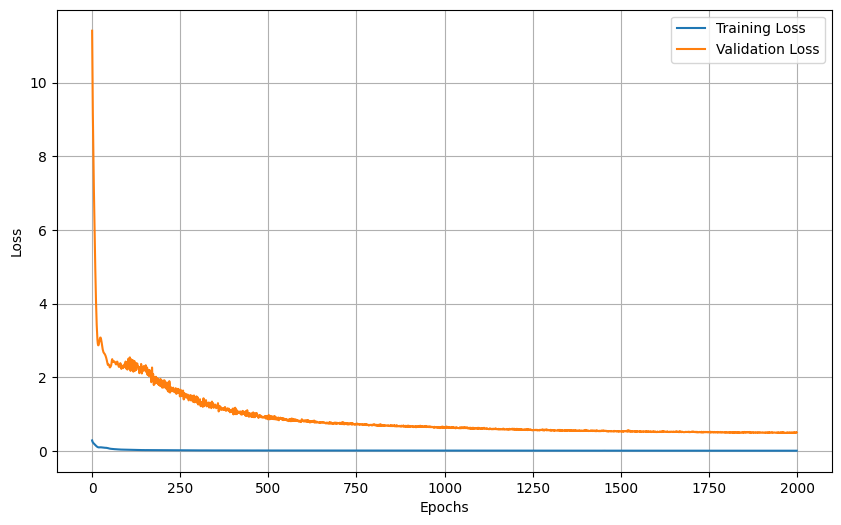

In [48]:
# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(range(2000), training_losses, label='Training Loss')
plt.plot(range(2000), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()